In [1]:
# Training a simple CNN on Fashion-MNIST and saving the model.
# This code will:
# - load the Fashion MNIST dataset
# - build and train a CNN (Conv2D, MaxPooling, Dropout)
# - plot training accuracy & loss
# - display a classification report and confusion matrix
# - save the trained model to /mnt/data/fashion_mnist_cnn
# If you want different hyperparameters, tell me and I'll regenerate.

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import pandas as pd

In [2]:
# Load Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()



4422102/4422102 [==============================] - 33s 7us/step


In [3]:
# Preprocess
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


In [4]:
# Expand dims for channel
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [5]:
# Build model
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

In [7]:
# Callbacks
save_dir = 'fashion_mnist_cnn'
os.makedirs(save_dir, exist_ok=True)
checkpoint_path = os.path.join(save_dir, 'best_model.h5')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]



Epoch 1/8
413/413 - 14s - loss: 0.3349 - accuracy: 0.8772 - val_loss: 0.2877 - val_accuracy: 0.8911 - 14s/epoch - 33ms/step
Epoch 2/8
413/413 - 14s - loss: 0.3207 - accuracy: 0.8826 - val_loss: 0.2773 - val_accuracy: 0.8946 - 14s/epoch - 33ms/step
Epoch 3/8
413/413 - 15s - loss: 0.3074 - accuracy: 0.8888 - val_loss: 0.2717 - val_accuracy: 0.8976 - 15s/epoch - 36ms/step
Epoch 4/8
413/413 - 14s - loss: 0.2988 - accuracy: 0.8907 - val_loss: 0.2628 - val_accuracy: 0.8982 - 14s/epoch - 34ms/step
Epoch 5/8
413/413 - 15s - loss: 0.2843 - accuracy: 0.8968 - val_loss: 0.2535 - val_accuracy: 0.9072 - 15s/epoch - 36ms/step
Epoch 6/8
413/413 - 16s - loss: 0.2798 - accuracy: 0.8975 - val_loss: 0.2551 - val_accuracy: 0.9025 - 16s/epoch - 38ms/step
Epoch 7/8
413/413 - 15s - loss: 0.2739 - accuracy: 0.9002 - val_loss: 0.2472 - val_accuracy: 0.9076 - 15s/epoch - 36ms/step
Epoch 8/8
413/413 - 15s - loss: 0.2658 - accuracy: 0.9012 - val_loss: 0.2412 - val_accuracy: 0.9099 - 15s/epoch - 37ms/step

Test ac

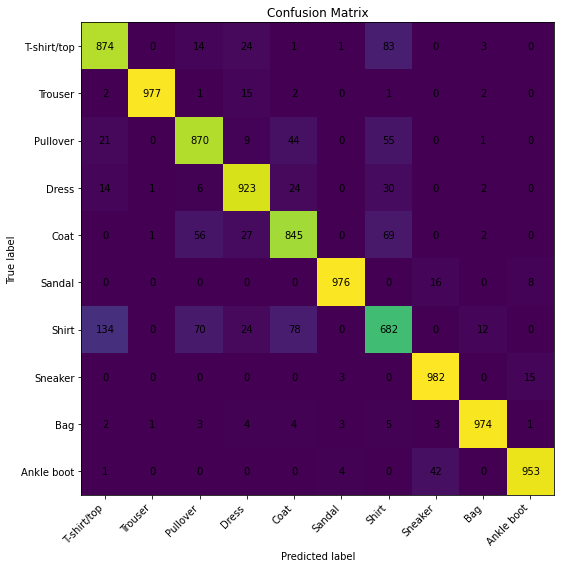

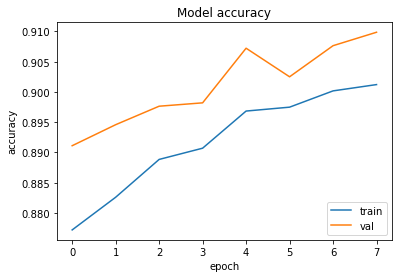

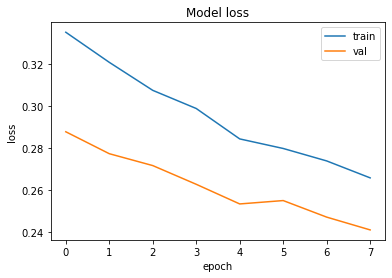

INFO:tensorflow:Assets written to: fashion_mnist_cnn\saved_model\assets


INFO:tensorflow:Assets written to: fashion_mnist_cnn\saved_model\assets



Model saved to: fashion_mnist_cnn
Best checkpoint: fashion_mnist_cnn\best_model.h5
SavedModel dir: fashion_mnist_cnn\saved_model


In [8]:
# Train
history = model.fit(x_train, y_train_cat,
                    epochs=8,
                    batch_size=128,
                    validation_split=0.12,
                    callbacks=callbacks,
                    verbose=2)

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\nTest accuracy: {test_acc:.4f}, test loss: {test_loss:.4f}")

# Predictions and report
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

try:
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Classification Report (Fashion MNIST)", df_report)
except Exception as e:
    print("Could not generate/display classification report table:", e)

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(np.arange(len(classes)), classes, rotation=45, ha='right')
plt.yticks(np.arange(len(classes)), classes)
# annotate
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             verticalalignment="center")
plt.tight_layout()
plt.show()

# Plot training curves: accuracy and loss (separate plots as required)
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Save final model in SavedModel format too
saved_model_dir = os.path.join(save_dir, 'saved_model')
model.save(saved_model_dir, save_format='tf')

print(f"\nModel saved to: {save_dir}")
print(f"Best checkpoint: {checkpoint_path}")
print(f"SavedModel dir: {saved_model_dir}")